# Лабораторная 4: Ранжирование

## Выполнила: Егорова Вера

In [1]:
%pylab inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.datasets import load_svmlight_files, load_svmlight_file, dump_svmlight_file
import regex as re
from random import shuffle
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib


## Поисковое ранжирование
Имеется множество документов $d \in D$ и множество запросов $q \in Q$. В задаче поискового ранжирования требуется оценивать *степень релевантности* документа по отношению к запросу: $(q, d) \mapsto r$. Данная зависимость восстанавливается при помощи машинного обучения. Для этого извлекают признаки из запроса $q$: (мешок слов текста запроса, его длина и т.д.), документа $d$ (значение PageRank, мешок слов, доменное имя), а так же из пары 
$(q, d)$ (число вхождений фразы из запроса $q$ в документе $d$). Для обучения используют оценки асессоров.

Важная отличительная особенность задачи ранжирования от классических задач машинного обучения заключается в том, что качество результата зависит не от предсказанных оценок релевантности, а от порядка следования документов в рамках конкретного запроса. Важно не абсолютное значение релевантности (его достаточно трудно формализовать в виде числа), а то, более или менее релевантен документ, относительно другого документа.

![](http://i.imgur.com/2QnD2nF.jpg)

## Метрики ранжирования

Оценивание качества ранжирования найденных документов в поиске производится по асессорским оценкам на скрытых от обучения запросах $Queries$. Для этого традиционно используется метрика *DCG* ([Discounted Cumulative Gain](https://en.wikipedia.org/wiki/Discounted_cumulative_gain)) и ее нормализованный вариант — *nDCG*, всегда принимающий значения от 0 до 1.
Для одного запроса DCG считается следующим образом:
$$ DCG = \sum_{i=1}^P\frac{(2^{rel_i} - 1)}{\log_2(i+1)} $$

где $P$ — число документов в поисковой выдаче, $rel_i$ — релевантность (асессорская оценка) документа, находящегося на i-той позиции.

*IDCG* — идеальное (наибольшее из возможных) значение *DCG*, может быть получено путем ранжирования документов по убыванию асессорских оценок.

Итоговая формула для расчета *nDCG*:

$$nDCG = \frac{DCG}{IDCG} \in [0, 1]$$

Чтобы оценить значение *nDCG* на выборке $Queries$ ($nDCG_{Queries}$), необходимо усреднить значение *nDCG* по всем запросам  выборки:
$$nDCG_{Queries} = \frac{1}{N}\sum_{q \in Queries}nDCG(q)$$
где $N$ - количество запросов в $Queries$.

## Данные

 - Загрузите данные конкурса [Интернет-математика 2009](http://imat2009.yandex.ru/datasets). Там же находится описание данных.
 - Разбейте обучающую выборку на обучение и контроль в соотношении 70 / 30. Обратите внимание на формат данных: разбивать необходимо множество запросов, а не строчки датасета.

Либо я не нашла, как это обойти, либо с форматом исходного датасета что-то не так. SVMLight предполагает, что query id будет записан как $qid:\langle integer\rangle$, а не $ \# \langle queryid \rangle$, как в исходном датасете. Исправим эту ошибку, чтобы бибилиотечная функция sklearn.load_svmlight_files смогла его распарсить.

In [2]:
def replace_qid(file_in, file_out):
    with open(file_in, 'r') as fin:
        with open(file_out, 'w') as fout:
            for line in fin.readlines():
                line = re.sub(r'(\d) ([\d\:\s+\.]+) # (\d+)', r'\1 qid:\3 \2', line)
                fout.write(line)
replace_qid('imat2009-datasets/imat2009_learning.txt', 'train_data.txt')
replace_qid('imat2009-datasets/imat2009_test.txt', 'test_data.txt')

In [2]:
data = load_svmlight_file('train_data.txt', query_id=True)

/Library/Python/2.7/site-packages/numpy-1.10.1-py2.7-macosx-10.10-intel.egg/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [3]:
train_data, train_labels, train_queries = data[0], data[1], data[2]
# test_data, test_labels, test_queries = data[3], data[4], data[5]
print train_data.shape, len(train_queries)

(97290, 245) 97290


Итак, всего уникальных запросов в тренировочном сете:

In [4]:
queries_number = len(set(train_queries))
print 'Queries number: ', queries_number

Queries number:  9124


In [83]:
train_set_size = int(queries_number * 0.7)

all_queries = list(set(train_queries))
train_queries_set = set(all_queries[:train_set_size])
validate_queries_set = set(all_queries[train_set_size:])
print 'Train queries:', train_set_size
print 'Validate queries:', len(validate_queries_set)

Train queries: 6386
Validate queries: 2738


In [80]:
all_queries[:train_set_size][:20]

[2, 3, 4, 6, 8, 9, 13, 17, 19, 23, 25, 33, 34, 38, 41, 42, 43, 48, 49, 50]

Разобьем обучающую выборку на train и validate.

In [85]:
train_X, train_y, train_qid = [], [], []
validate_X, validate_y, validate_qid = [], [], []
train_dict = defaultdict(list)
validate_dict = defaultdict(list)
train_data_dense = zip(train_data.todense().A, train_labels)
for row, qid in zip(train_data_dense, train_queries):
    if qid in train_queries_set:
        train_dict[qid].append(len(train_X))
        train_X.append(row[0])
        train_y.append(row[1])
        train_qid.append(qid)
    else:
        validate_dict[qid].append(len(validate_X))
        validate_X.append(row[0])
        validate_y.append(row[1])
        validate_qid.append(qid)
print 'Train set size:', len(train_X)
print 'Validate set size:', len(validate_X)
print len(train_X)+len(validate_X)

Train set size: 73245
Validate set size: 24045
97290


## Модели

### Линейный Point-wise подход

Воспользовавшись известными техниками построения линейной регрессии, обучите модель, предсказывающую оценку асессора.

In [7]:
lin_reg_clf = LinearRegression()
lin_reg_clf.fit(train_X, [x for x in train_y])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [8]:
lr_predict = lin_reg_clf.predict(validate_X)

In [10]:
def dcg_score(y_true, y_score, k=10):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)


def ndcg_score(y_true, y_score, k=10):
    best = dcg_score(y_true, y_true, k)
    actual = dcg_score(y_true, y_score)
    return actual / best


In [39]:
def calculate_NDCG(real, predicted, query_dict):
    total_NDCG = []
    for qid, scores in query_dict.items():
        y_true = [real[i] for i in scores]
        if any([x for x in y_true]):
            y_score = [predicted[i] for i in scores]
            NDCG = ndcg_score(y_true, y_score, len(scores))
            total_NDCG.append(NDCG)
    return sum(total_NDCG) / len(total_NDCG)
lr_NDCG = calculate_NDCG(validate_y, lr_predict, validate_dict)
print 'NDCG score:', lr_NDCG

NDCG score: 0.81918943535


In [171]:
scores = {}
scores['Linear point-wise'] = lr_NDCG

### Линейный Pair-wise подход

Постройте ранжирующую модель при помощи [SVMlight](http://www.cs.cornell.edu/people/tj/svm_light/svm_rank.html), реализующий Ranking SVM.

Сохраним наши train_X, train_y в формате svmlight

In [13]:
def prepare(X, y, qid):
    data = sorted(zip(zip(X, y), qid), key = lambda x: x[1])
    strain_X = [x[0][0] for x in data]
    strain_y = [x[0][1] for x in data]
    strain_qid = [x[1] for x in data]
    return strain_X, strain_y, strain_qid
strain_X, strain_y, strain_qid = prepare(train_X, train_y, train_qid)
svalidate_X, svalidate_y, svalidate_qid = prepare(validate_X, validate_y, validate_qid)

In [38]:
dump_svmlight_file(strain_X, strain_y, open('train.dat', 'w'), zero_based=False, query_id=strain_qid)
dump_svmlight_file(svalidate_X, svalidate_y, open('test.dat', 'w'), zero_based=False, query_id=svalidate_qid)

In [39]:
!./svm_rank/svm_rank_learn -c 6386 train.dat model.dat

Reading training examples...done
Training set properties: 245 features, 6386 rankings, 73245 examples
NOTE: Adjusted stopping criterion relative to maximum loss: eps=0.043129
Iter 1: .........*(NumConst=1, SV=1, CEps=43.1290, QPEps=0.0000)
Iter 2: .........*(NumConst=2, SV=2, CEps=53.7813, QPEps=0.0000)
Iter 3: .........*(NumConst=3, SV=3, CEps=74.3910, QPEps=0.0000)
Iter 4: .........*(NumConst=4, SV=4, CEps=75.6318, QPEps=0.0000)
Iter 5: .........*(NumConst=5, SV=5, CEps=92.8981, QPEps=0.0000)
Iter 6: .........*(NumConst=6, SV=5, CEps=112.0159, QPEps=0.0000)
Iter 7: .........*(NumConst=7, SV=6, CEps=68.3750, QPEps=0.0000)
Iter 8: .........*(NumConst=8, SV=7, CEps=80.6773, QPEps=0.0000)
Iter 9: .........*(NumConst=9, SV=8, CEps=139.5948, QPEps=0.0001)
Iter 10: .........*(NumConst=10, SV=8, CEps=212.1768, QPEps=0.0001)
Iter 11: .........*(NumConst=11, SV=9, CEps=186.4797, QPEps=0.0000)
Iter 12: .........*(NumConst=12, SV=10, CEps=202.3988, QPEps=9.1612)
Iter 13: .........*(NumConst=13, 

In [40]:
!./svm_rank/svm_rank_classify test.dat model.dat predictions.dat

Reading model...done.
Reading test examples...done.
Classifying test examples...done
Runtime (without IO) in cpu-seconds: 0.01
Average loss on test set: 0.2818
Zero/one-error on test set: 69.69% (830 correct, 1908 incorrect, 2738 total)
NOTE: The loss reported above is the fraction of swapped pairs averaged over
      all rankings. The zero/one-error is fraction of perfectly correct
      rankings!
Total Num Swappedpairs  :  21873
Avg Swappedpairs Percent:  28.18


In [14]:
svm_predict = []
with open('predictions.dat', 'r') as fin:
    for line in fin.readlines():
        svm_predict.append(float(line.strip()))
print len(svm_predict), len(validate_y)

24045 24045


In [113]:
svm_NDCG = calculate_NDCG(svalidate_y, svm_predict, validate_dict)
print 'SVM NDCG score:', svm_NDCG

SVM NDCG score: 0.837673861815


In [172]:
scores['Linear pair-wise']=svm_NDCG

### Линейный Pair-wise transform

Обучите SVM для бинарной классификации на новой обучающей выборке. В качестве объектов в ней будут все возможные упорядоченные пары различных документов в рамках каждого запроса. Целевая бинарная метка — факт того, что первый документ в паре более релевантный чем второй. Придумайте несколько эвристик, как использовать предсказания бинарного классификатора, обученного на таких данных, для ранжирования списка документов по новому запросу.

In [16]:
def prepare_data(X, y, q_dict, size):
    new_X, new_y = [], []
    for qid, indices in sorted(q_dict.items())[:size]:
        for i in sorted(indices):
            for j in sorted(indices):
                if j >= i:
                    break
                new_X.append(np.concatenate([X[i], X[j]], axis=0))
                new_y.append(int(y[i]>y[j]))
    return new_X, new_y

ttrain_X, ttrain_y = prepare_data(train_X, train_y, train_dict, 200)
print len(train_X), len(ttrain_X)

73245 221852


In [17]:
svm = LinearSVC()
svm.fit(ttrain_X, ttrain_y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

#### Эвристика № 1: Позиция в отсортированном списке

Первое, что приходит в голову, это использовать порядок, полученный от бинарного классификатора в качестве функции-компоратора для алгоритма сортировки. С его помощью мы можем отсортировать список документов, согласно предсказанию классификатора. Степень релевантности будем определять по формуле: <br>
$$r(q, d) = (N - k)*$$
где N - число документов в списке, k -  позиция документа в отсортированном списке

In [18]:
def comparer(x, y):
    res = svm.predict([np.concatenate([validate_X[x], validate_X[y]], axis=0)])
    return 1 if res[0] else -1

In [22]:
total_NDCG = []
for qid, scores in validate_dict.items():
    y_true = [validate_y[i] for i in scores]
    if any([x for x in y_true]):
        data = sorted([i for i in scores], cmp=comparer)
        y_score = [((len(scores)-data.index(i))) for i in scores]
        NDCG = ndcg_score(y_true, y_score, len(validate_dict[qid]))
        total_NDCG.append(NDCG)
transf_NDCG_H1 = sum(total_NDCG) / len(total_NDCG)
print 'Pair-wise transform NDCG:', transf_NDCG_H1

Pair-wise transform NDCG: 0.702352575768


Получилось как-то неочень. NDCG меньше, чем во всех предыдущих экспериментах.

In [173]:
scores['Linear pair-wise transform h1'] = transf_NDCG_H1

#### Эвристика № 2: Количество "удачных" пар

In [25]:
def calculate_rank(i, qid):
    rank = 0.
    for j in validate_dict[qid]:
        if j == i: continue
        res = svm.predict([np.concatenate([validate_X[i], validate_X[j]], axis=0)])
        if res[0]: rank += 1
    return rank

In [26]:
total_NDCG = []
for qid, scores in validate_dict.items():
    y_true = [validate_y[i] for i in scores]
    if any([x for x in y_true]):
        data = sorted([i for i in scores], cmp=comparer)
        y_score = [calculate_rank(i, qid) for i in scores]
        NDCG = ndcg_score(y_true, y_score, len(validate_dict[qid]))
        total_NDCG.append(NDCG)
transf_NDCG_H2 = sum(total_NDCG) / len(total_NDCG)
print 'Pair-wise transform NDCG:', transf_NDCG_H2

Pair-wise transform NDCG: 0.772063769677


Эта эвристика немного повысила качество ранжирования.

In [174]:
scores['Linear pair-wise transform h2'] = transf_NDCG_H2

### Бустинг над деревьями

Воспользуйтесь библиотекой [XGBoost](https://github.com/dmlc/xgboost):
    - Обучите point-wise и pair-wise модели: в первом случае используйте квадратичную функцию потерь (*objective="reg:linear"*), во втором - ранжирующую (*objective="rank:pairwise"*). В качестве метрики (*eval_metric*) используйте *nDCG*, в качестве бустера - *gbtree*.
    - Рассмотрите различные параметры бустера.

In [105]:
def get_unique(qids):
    unique = []
    prev = -1
    for qid in qids:
        if qid != prev:
            unique.append(qid)
            prev=qid
        
    return unique

In [184]:
gb_train_X, gb_train_y = np.array(train_X), np.array(train_y)
train_group_sizes = [len(train_dict[k]) for k in get_unique(train_qid)]
gb_validate_X, gb_validate_y = np.array(validate_X), np.array(validate_y)
validate_group_sizes = [len(validate_dict[k]) for k in get_unique(validate_qid)]
dtrain = xgb.DMatrix(gb_train_X, gb_train_y)
dtrain.set_group(train_group_sizes)
dtest = xgb.DMatrix(gb_validate_X, gb_validate_y)
dtest.set_group(validate_group_sizes)

In [185]:
param = {'objective':'reg:linear', 'booster':'gbtree',
        'eval_metric':'ndcg', 'nthread':4}
evallist  = [(dtest,'eval'), (dtrain,'train')]

In [186]:
bst = xgb.train(param, dtrain, 50, evallist)

[0]	eval-:0.850803	train-:0.836256
[1]	eval-:0.856147	train-:0.847583
[2]	eval-:0.863157	train-:0.855247
[3]	eval-:0.864878	train-:0.858633
[4]	eval-:0.867045	train-:0.860862
[5]	eval-:0.869676	train-:0.863555
[6]	eval-:0.870421	train-:0.865846
[7]	eval-:0.872395	train-:0.867967
[8]	eval-:0.875075	train-:0.870215
[9]	eval-:0.874255	train-:0.872295
[10]	eval-:0.875107	train-:0.873957
[11]	eval-:0.876018	train-:0.875724
[12]	eval-:0.876912	train-:0.876565
[13]	eval-:0.876861	train-:0.877381
[14]	eval-:0.877357	train-:0.878422
[15]	eval-:0.876877	train-:0.879415
[16]	eval-:0.877383	train-:0.879951
[17]	eval-:0.878377	train-:0.881189
[18]	eval-:0.877751	train-:0.882451
[19]	eval-:0.878331	train-:0.883149
[20]	eval-:0.878026	train-:0.883953
[21]	eval-:0.877639	train-:0.884914
[22]	eval-:0.878454	train-:0.885774
[23]	eval-:0.878344	train-:0.886741
[24]	eval-:0.878664	train-:0.886956
[25]	eval-:0.878494	train-:0.887872
[26]	eval-:0.878513	train-:0.889067
[27]	eval-:0.879010	train-:0.889775
[2

In [189]:
predict = bst.predict(dtest)
bst_NDCG = calculate_NDCG(validate_y, predict, validate_dict)
print 'Boost Quad NDCG score:', bst_NDCG

Boost Quad NDCG score: 0.835132891609


In [190]:
scores['Boosting reg:linear']=bst_NDCG

In [119]:
param = {'objective':'rank:pairwise', 'booster':'gbtree',
        'eval_metric':'ndcg', 'nthread':4}

In [ ]:
dtrain = xgb.DMatrix(gb_train_X, gb_train_y)
dtrain.set_group(train_group_sizes)
dtest = xgb.DMatrix(gb_validate_X, gb_validate_y)
dtest.set_group(validate_group_sizes)

In [120]:
bst_rang = xgb.train(param, dtrain, 50, evallist)

[0]	eval-:0.844069	train-:0.828991
[1]	eval-:0.851002	train-:0.840799
[2]	eval-:0.856358	train-:0.847673
[3]	eval-:0.858121	train-:0.851609
[4]	eval-:0.859626	train-:0.855321
[5]	eval-:0.861215	train-:0.859329
[6]	eval-:0.861272	train-:0.861367
[7]	eval-:0.861868	train-:0.862834
[8]	eval-:0.861487	train-:0.864947
[9]	eval-:0.864209	train-:0.866610
[10]	eval-:0.866053	train-:0.869012
[11]	eval-:0.867077	train-:0.870800
[12]	eval-:0.867686	train-:0.873386
[13]	eval-:0.869079	train-:0.875520
[14]	eval-:0.870173	train-:0.877812
[15]	eval-:0.869800	train-:0.878056
[16]	eval-:0.870668	train-:0.880155
[17]	eval-:0.870534	train-:0.881603
[18]	eval-:0.870945	train-:0.882104
[19]	eval-:0.870847	train-:0.883379
[20]	eval-:0.870461	train-:0.884030
[21]	eval-:0.871615	train-:0.885237
[22]	eval-:0.871225	train-:0.886245
[23]	eval-:0.871402	train-:0.886994
[24]	eval-:0.871596	train-:0.887383
[25]	eval-:0.871695	train-:0.888303
[26]	eval-:0.872113	train-:0.889940
[27]	eval-:0.872432	train-:0.890181
[2

In [191]:
predict = bst_rang.predict(dtest)
bst_NDCG = calculate_NDCG(validate_y, predict, validate_dict)
print 'Boost Rank NDCG score:', bst_NDCG

Boost Rank NDCG score: 0.831416435722


In [192]:
scores['Boosting rank:pairwise']=bst_NDCG

## Оценка качества

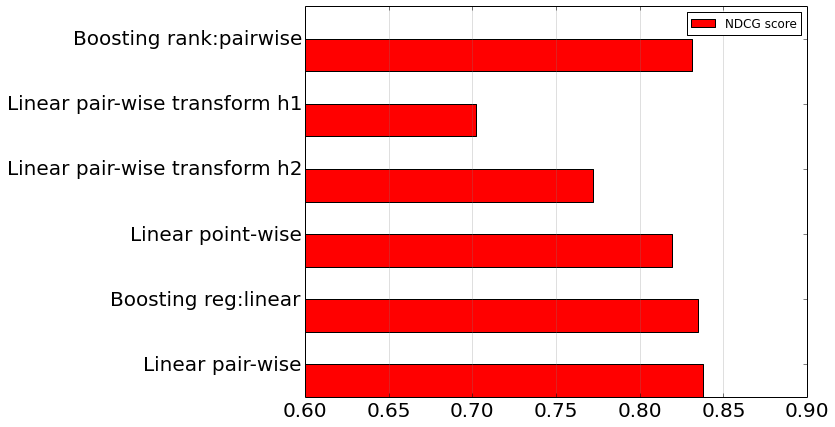

In [193]:
ind = np.arange(len(scores))
width = 0.5
fig, ax = plt.subplots(figsize=(9, 7))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
ax.barh(ind, scores.values(), width, color='red', label='NDCG score')

ax.set(yticks=ind + width, yticklabels=scores.keys(), ylim=[2*width - 1, len(scores)])
ax.set_xlim(0.6, 0.9)
ax.xaxis.grid(True, linestyle='-', which='major',
                   color='grey', alpha=.5)
ax.legend()

plt.show()

На графике представлены оценки качества полученных моделей с точки зрения метрики NDCG на контрольной выборке.
- Получилось, что для данной задачи лучший результат показал градиентный бустинг с квадратичной функуцией потерь $(NDCG = 0.835)$ Хотя, он не далеко ушел от второго варианта бустинга и linear pair-wise модели.
- Основныем недостатком линейных pair-wise моделей является необходимость формировать все возможные пары документов. Это очень трудоемкая задача. Подход в лоб, которым я строила все пары, точно не подходит. Если не уменьшать множество тренировочных запросов, то у меня получилась выборка объемом более 1млн запросов. На такой выборке мне бы не хватило ни памяти, ни времени, чтобы обучить SVM.
- Для pair-wise transform у меня получились самые слабенькие модели. Отчасти из-за того, что я сузила множество запросов, также может стоило использовать другие эвристики. Ranking SVM значительно превосходит эти алгоритмы по качеству.
- Линейный point-wise подход дает модель похуже, чем Ranking SVM и Gradient Boost. Но ему удалось превзойти pair-wise transform модели.
- Бустинг с квадратичной функцией потерь первосходит в качестве линейный point-wise подход. Разница при использовании бустина с различными функциями потерь незначительна.
